In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import os
import copy
import pandas as pd
from PIL import Image, UnidentifiedImageError
from collections import Counter
from torch.hub import load_state_dict_from_url


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on device: {device}")

Working on device: cuda


In [3]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=128),
    transforms.RandomRotation(15), 
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33)), 
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
trainDataset = datasets.ImageFolder(root='/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/train', transform=train_transforms)
valDataset   = datasets.ImageFolder(root='/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/train', transform=val_transforms)

targets = trainDataset.targets
#split by index, not the actual data
train_idx, val_idx = train_test_split(
    np.arange(len(targets)), 
    test_size=0.2,           #80/20 split
    shuffle=True, 
    stratify=targets     #to keep the same distribution of classes in both sets
)

train_subset = Subset(trainDataset, train_idx)
val_subset   = Subset(valDataset, val_idx)

In [5]:
counter = Counter(trainDataset.targets)
for class_index, count in counter.most_common():
    class_name = trainDataset.classes[class_index]
    print(f"{class_name}: {count}")

boho: 918
eclectic: 809
modern: 809
farmhouse: 795
coastal: 794
mediterranean: 789
french-country: 788
contemporary: 782
asian: 779
southwestern: 772
tropical: 772
scandinavian: 768
craftsman: 764
industrial: 764
victorian: 759
shabby-chic-style: 746
minimalist: 555


In [6]:
train_targets = np.array(targets)[train_idx] #get all the training targets

#calculate the weights
class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts

#map each label to its weight
sample_weights = class_weights[train_targets] #this create an array of len(train_targets), and its like every we are indexing by the target label 
sample_weights = torch.from_numpy(sample_weights).double()

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [7]:
train_loader = DataLoader(
    train_subset, 
    batch_size=32, 
    sampler=train_sampler,
    num_workers=4
)

val_loader = DataLoader(
    val_subset, 
    batch_size=32, 
    shuffle=False,        
    num_workers=4
)

In [8]:
print(f"Training on {len(train_subset)} images.")
print(f"Validating on {len(val_subset)} images.")

Training on 10530 images.
Validating on 2633 images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

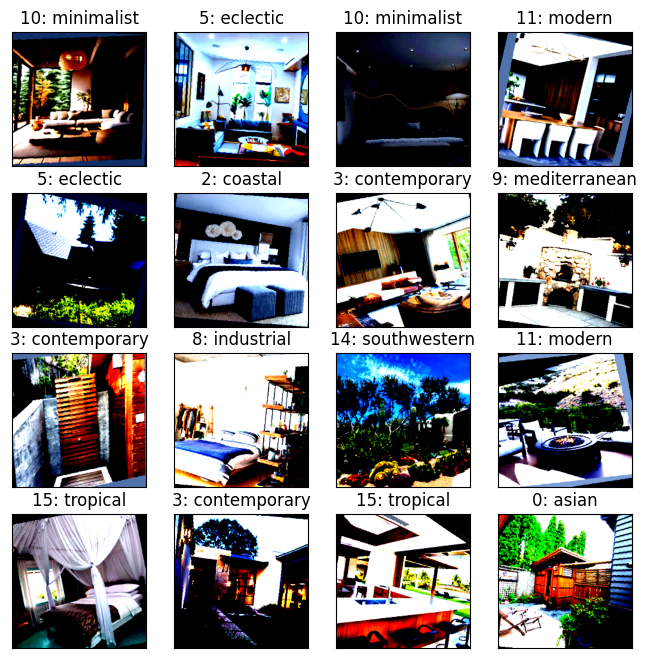

In [9]:
import matplotlib.pyplot as plt

indoorStyleClasses = trainDataset.classes

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    
    img_display = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img_display)
    idx = labels[i].item()
    real_name = indoorStyleClasses[idx]
    
    ax.set_title(f"{idx}: {real_name}")

plt.show()

# MobileNetV2 Model

In [10]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, norm_layer=nn.BatchNorm2d):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, norm_layer=nn.BatchNorm2d):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear (This was the issue! The last layer must NOT have ReLU)
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0, inverted_residual_setting=None, round_nearest=8):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        norm_layer = nn.BatchNorm2d
        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        
        # building first layer
        features = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
                
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        
        self.features = nn.Sequential(*features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
def get_mobilenet_scratch_custom(num_classes=17):
    print("Building Custom MobileNetV2 from Scratch...")
    
    # 1. Initialize with 1000 classes strictly to match weights structure
    model = MobileNetV2(num_classes=1000)
    
    # 2. Load Weights (Safe Mode)
    url = 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth'
    state_dict = load_state_dict_from_url(url, progress=True)
    
    try:
        model.load_state_dict(state_dict)
        print("ImageNet weights loaded successfully (Exact Match).")
    except RuntimeError as e:
        print(f"Ignorable mismatch in classifier (expected): {e}")
     
        model.load_state_dict(state_dict, strict=False)

    # 3. Freeze Backbone
    for param in model.features.parameters():
        param.requires_grad = False
        
    # 4. Modify Head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features, num_classes)
    )
    
    return model

model = get_mobilenet_scratch_custom(num_classes=17).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # As per your logic

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Building Custom MobileNetV2 from Scratch...


100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s]


ImageNet weights loaded successfully (Exact Match).


In [12]:
print("\n=== Phase 1: Warming up Classifier (Backbone Frozen) ===")

optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-3)

num_epochs_warmup = 5

for epoch in range(num_epochs_warmup):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(f"Warmup Epoch {epoch+1}/{num_epochs_warmup}]")
    print(f"Loss: {running_loss/len(train_loader):.4f} | Acc: {100*correct/total:.2f}%")
    print("-" * 50)
    



=== Phase 1: Warming up Classifier (Backbone Frozen) ===
Warmup Epoch 1/5]
Loss: 2.6187 | Acc: 20.15%
--------------------------------------------------
Warmup Epoch 2/5]
Loss: 2.4648 | Acc: 26.05%
--------------------------------------------------
Warmup Epoch 3/5]
Loss: 2.4502 | Acc: 27.08%
--------------------------------------------------
Warmup Epoch 4/5]
Loss: 2.4532 | Acc: 27.21%
--------------------------------------------------
Warmup Epoch 5/5]
Loss: 2.4411 | Acc: 28.23%
--------------------------------------------------


In [13]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("\n=== Phase 2: Fine-Tuning Whole Model (Unfrozen + Differential LR) ===")

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 2. Differential Learning Rates
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 2e-5}, 
    {'params': model.classifier.parameters(), 'lr': 2e-4} 
], weight_decay=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs_finetune = 30 
best_acc = 0.0
save_path = 'best_mobilenet_v2_robust.pth'
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs_finetune):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total
    
    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / val_total
    
    scheduler.step(epoch_val_loss)
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs_finetune}]")
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
    print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.2f}%")
    print("-" * 50)
    
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), save_path)
        print(f"--> Best Model Saved! (Acc: {best_acc:.2f}%)")

print("Training Complete.")


=== Phase 2: Fine-Tuning Whole Model (Unfrozen + Differential LR) ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30]
Train Loss: 2.2788 | Train Acc: 32.96%
Val   Loss: 2.1821 | Val   Acc: 36.73%
--------------------------------------------------
--> Best Model Saved! (Acc: 36.73%)
Epoch [2/30]
Train Loss: 2.1849 | Train Acc: 36.82%
Val   Loss: 2.1398 | Val   Acc: 37.49%
--------------------------------------------------
--> Best Model Saved! (Acc: 37.49%)
Epoch [3/30]
Train Loss: 2.1327 | Train Acc: 38.77%
Val   Loss: 2.1306 | Val   Acc: 38.78%
--------------------------------------------------
--> Best Model Saved! (Acc: 38.78%)
Epoch [4/30]
Train Loss: 2.0631 | Train Acc: 41.47%
Val   Loss: 2.0832 | Val   Acc: 40.52%
--------------------------------------------------
--> Best Model Saved! (Acc: 40.52%)
Epoch [5/30]
Train Loss: 1.9889 | Train Acc: 44.62%
Val   Loss: 2.0848 | Val   Acc: 40.75%
--------------------------------------------------
--> Best Model Saved! (Acc: 40.75%)
Epoch [6/30]
Train Loss: 1.9789 | Train Acc: 44.79%
Val   Loss: 2.1143 | Val   Acc: 39.16%
-------------------

In [14]:
import pandas as pd
import torch.nn.functional as F 

class RobustTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        try:
            image = Image.open(img_path).convert("RGB")
        except (UnidentifiedImageError, OSError):
            print(f"Warning: Corrupted image {img_name}. Using black placeholder.")
            image = Image.new('RGB', (224, 224), color='black')
            
        if self.transform:
            image = self.transform(image)
        return image, img_name

print(f"Loading best weights with Accuracy: {best_acc:.2f}%")
model.load_state_dict(best_model_wts)
model.eval()

test_dir = '/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/test'
test_dataset = RobustTestDataset(root_dir=test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

predictions = []
file_names = []

print("Generating predictions with TTA (Class IDs)...")

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        
     
        outputs_orig = model(images)
        probs_orig = F.softmax(outputs_orig, dim=1) 
        
        images_flipped = torch.flip(images, dims=[3]) 
        outputs_flipped = model(images_flipped)
        probs_flipped = F.softmax(outputs_flipped, dim=1)
        
        avg_probs = (probs_orig + probs_flipped) / 2.0
        
        _, preds = torch.max(avg_probs, 1)
        

        for pred in preds:
            predictions.append(pred.item()) 
            
        file_names.extend(names)

submission = pd.DataFrame({'ImageName': file_names, 'ClassLabel': predictions})

submission['ImageName'] = submission['ImageName'].astype(str)
submission['ClassLabel'] = submission['ClassLabel'].astype(int)

submission.to_csv('submission.csv', index=False)
print("Done! 'submission.csv' is ready with Integer Labels & TTA Boost.")
print(submission.head())

Loading best weights with Accuracy: 44.63%
Generating predictions with TTA (Class IDs)...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Done! 'submission.csv' is ready with Integer Labels & TTA Boost.
            ImageName  ClassLabel
0     testimage_1.jpg          14
1    testimage_10.jpg           7
2   testimage_100.jpg          10
3  testimage_1000.jpg           2
4  testimage_1001.jpg          10


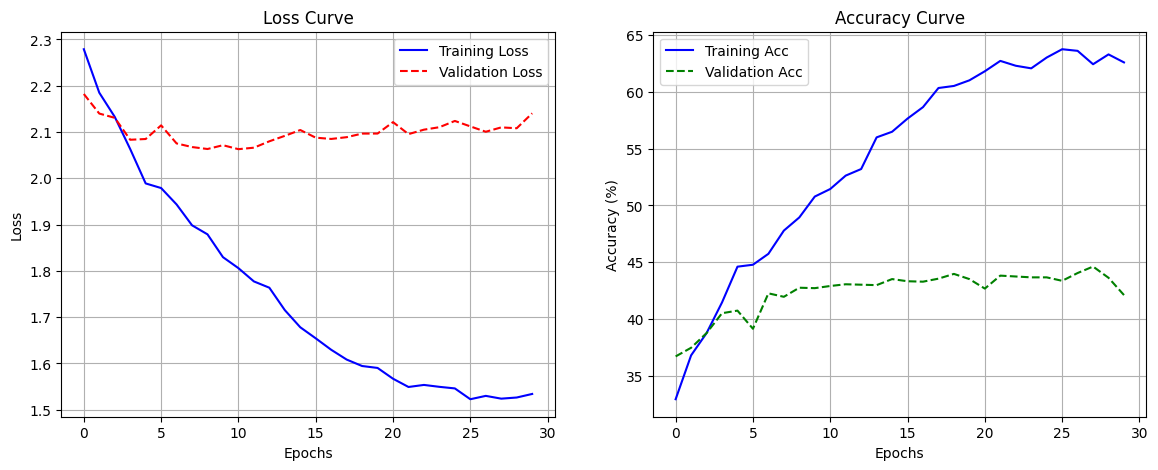

In [15]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r--', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, 'b-', label='Training Acc')
plt.plot(val_accs, 'g--', label='Validation Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.savefig('learning_curves.png') 
plt.show()

# Test Script

In [16]:
import torch.nn.functional as F

class RobustTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        try:
            image = Image.open(img_path).convert("RGB")
        except (UnidentifiedImageError, OSError):
            image = Image.new('RGB', (224, 224), color='black')
        if self.transform:
            image = self.transform(image)
        return image, img_name

# 2. Setup and Load
print(f"Loading best weights with Accuracy: {best_acc:.2f}%")

# Important: Initialize the same architecture
final_model = get_mobilenet_scratch_custom(num_classes=17).to(device)
# Load your trained weights
final_model.load_state_dict(torch.load('best_mobilenet_v2_robust.pth'))
final_model.eval()

# 3. Test Loader
test_dir = '/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/test'
test_dataset = RobustTestDataset(root_dir=test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

predictions = []
file_names = []

print("Generating predictions with TTA (Class IDs)...")

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        
        # TTA: Original + Flip
        outputs_orig = final_model(images)
        probs_orig = F.softmax(outputs_orig, dim=1) 
        
        images_flipped = torch.flip(images, dims=[3]) 
        outputs_flipped = final_model(images_flipped)
        probs_flipped = F.softmax(outputs_flipped, dim=1)
        
        avg_probs = (probs_orig + probs_flipped) / 2.0
        _, preds = torch.max(avg_probs, 1)

        for pred in preds:
            predictions.append(pred.item()) 
            
        file_names.extend(names)

# 4. Save Submission
submission = pd.DataFrame({'ImageName': file_names, 'ClassLabel': predictions})
submission['ImageName'] = submission['ImageName'].astype(str)
submission['ClassLabel'] = submission['ClassLabel'].astype(int)
submission.to_csv('submission.csv', index=False)
print("Done! 'submission.csv' is ready.")
print(submission.head())

Loading best weights with Accuracy: 44.63%
Building Custom MobileNetV2 from Scratch...
ImageNet weights loaded successfully (Exact Match).
Generating predictions with TTA (Class IDs)...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Done! 'submission.csv' is ready.
            ImageName  ClassLabel
0     testimage_1.jpg          14
1    testimage_10.jpg           7
2   testimage_100.jpg          10
3  testimage_1000.jpg           2
4  testimage_1001.jpg          10
